<a href="https://colab.research.google.com/github/itspreeti25/U-NET-implementation-for-segmentation/blob/main/mri_unet-segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [50]:
!nvidia-smi

Tue Apr 20 07:09:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    31W / 250W |  15563MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!sudo apt install python3.8

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libpython3.8-minimal libpython3.8-stdlib python3.8-minimal
Suggested packages:
  python3.8-venv python3.8-doc binfmt-support
The following NEW packages will be installed:
  libpython3.8-minimal libpython3.8-stdlib python3.8 python3.8-minimal
0 upgraded, 4 newly installed, 0 to remove and 31 not upgraded.
Need to get 4,669 kB of archives.
After this operation, 18.5 MB of additional disk space will be used.
Get:1 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic/main amd64 libpython3.8-minimal amd64 3.8.9-1+bionic1 [761 kB]
Get:2 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic/main amd64 python3.8-minimal amd64 3.8.9-1+bionic1 [1,823 kB]
Get:3 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic/main amd64 libpython3.8-stdlib amd64 3.8.9-1+bionic1 [1,656 kB]
Get:4 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic/main amd64 

In [ ]:
import tensorflow as tf
print(tf.__version__)


2.4.1


In [ ]:
!python --version

Python 3.7.10


In [44]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.regularizers import l1,l2
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import Recall, Precision
from keras.models import load_model

import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display
import re


In [4]:
data = pd.read_csv("/content/drive/MyDrive/Input_MRI_S/lgg-mri-segmentation/kaggle_3m/data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [ ]:
data.head(4)

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0


In [5]:
data_map = []
for sub_dir_path in glob.glob("/content/drive/MyDrive/Input_MRI_S/lgg-mri-segmentation/kaggle_3m/"+"*"):
    #if os.path.isdir(sub_path_dir):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)


[Errno 20] Not a directory: '/content/drive/MyDrive/Input_MRI_S/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/content/drive/MyDrive/Input_MRI_S/lgg-mri-segmentation/kaggle_3m/data.csv'


In [6]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head(4)
print(len(df))

7868


In [7]:
# df_imgs = df[~df['path'].str.contains("mask") & ~df['path'].str.contains("(1)") ]
# df_masks = df[df['path'].str.contains("mask") & ~df['path'].str.contains("(1)") ]

df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]


# File path line length images for later sorting
BASE_LEN = 110 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)



In [19]:
# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))



In [20]:
# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /content/drive/MyDrive/Input_MRI_S/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_48.tif 
Path to the Mask: /content/drive/MyDrive/Input_MRI_S/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_48_mask.tif


In [ ]:
len(df_imgs)

In [17]:
def fetch_num(path):
  try:
    num=int(path[BASE_LEN:-END_IMG_LEN])
    return num
  except Exception as e:
    print(path)
imgs = sorted(df_imgs["path"].values, key=fetch_num)



# def fetch_num(path):
#   try:
#     num=int(path[BASE_LEN:-END_MASK_LEN])
#     return num
#   except Exception as e:
#     print(path)



imgs = sorted(df_imgs["path"].values, key=fetch_num)

/content/drive/MyDrive/Input_MRI_S/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_1 (1).tif
/content/drive/MyDrive/Input_MRI_S/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_13 (1).tif
/content/drive/MyDrive/Input_MRI_S/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_11 (1).tif
/content/drive/MyDrive/Input_MRI_S/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_16 (1).tif
/content/drive/MyDrive/Input_MRI_S/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_12 (1).tif


TypeError: ignored

In [21]:
len(df_imgs)

3929

In [18]:
# df_imgs.drop(df_imgs[df_imgs['path'].str.contains("_(1)")].index, inplace = True)
# df_masks.drop(df_masks[df_masks['path'].str.contains("_(1)")].index, inplace = True)

df_imgs.drop(df_imgs[df_imgs['path']=="/content/drive/MyDrive/Input_MRI_S/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_10 (1).tif"].index, inplace = True)
df_imgs.drop(df_imgs[df_imgs['path']=="/content/drive/MyDrive/Input_MRI_S/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_1 (1).tif"].index, inplace = True)
df_imgs.drop(df_imgs[df_imgs['path']=="/content/drive/MyDrive/Input_MRI_S/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_13 (1).tif"].index, inplace = True)
df_imgs.drop(df_imgs[df_imgs['path']=="/content/drive/MyDrive/Input_MRI_S/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_11 (1).tif"].index, inplace = True)
df_imgs.drop(df_imgs[df_imgs['path']=="/content/drive/MyDrive/Input_MRI_S/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_16 (1).tif"].index, inplace = True)
df_imgs.drop(df_imgs[df_imgs['path']=="/content/drive/MyDrive/Input_MRI_S/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_12 (1).tif"].index, inplace = True)

df_masks.drop(df_masks[df_masks['path']=="/content/drive/MyDrive/Input_MRI_S/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_10_mask (1).tif"].index, inplace = True)
df_masks.drop(df_masks[df_masks['path']=="/content/drive/MyDrive/Input_MRI_S/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_12_mask (1).tif"].index, inplace = True)
df_masks.drop(df_masks[df_masks['path']=="/content/drive/MyDrive/Input_MRI_S/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_15_mask (1).tif"].index, inplace = True)
df_masks.drop(df_masks[df_masks['path']=="/content/drive/MyDrive/Input_MRI_S/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_17_mask (1).tif"].index, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### creating final datset

In [22]:
# Final dataframe
df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
df['mask'] = df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
df

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5396_20010302,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,0
1,TCGA_CS_5396_20010302,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,0
2,TCGA_CS_5396_20010302,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,0
3,TCGA_CS_5396_20010302,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,0
4,TCGA_CS_5396_20010302,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,0
...,...,...,...,...
3924,TCGA_HT_7684_19950816,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,0
3925,TCGA_HT_7684_19950816,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,0
3926,TCGA_HT_7684_19950816,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,0
3927,TCGA_HT_7684_19950816,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,0


In [49]:
df

,mri_scan,mask
0,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...
1,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...
2,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...
3,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...
4,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...
...,...,...
3924,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...
3925,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...
3926,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...
3927,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...,/content/drive/MyDrive/Input_MRI_S/lgg-mri-seg...


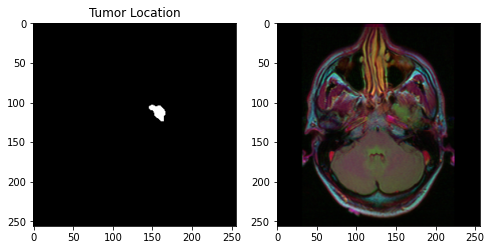

In [24]:
for i in range(len(df)):
    if cv2.imread(df.mask_path[i]).max() > 0:
        break

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(df.mask_path[i]));
plt.title('Tumor Location')

plt.subplot(1,2,2)
plt.imshow(cv2.imread(df.image_path[i]));

In [28]:
cv2.imread(df.mask_path[i]).max(), cv2.imread(df.mask_path[i]).min()

(255, 0)

In [29]:
brain_df_train = df.drop(columns=['patient_id'])



# # Convert the data in mask column to string format, to use categorical/binary mode in flow_from_dataframe
# brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
# brain_df_train.info()

# brain_df_mask = brain_df[brain_df['mask'] == 1]
# brain_df_mask.shape

In [ ]:


#for Classification
# from sklearn.model_selection import train_test_split

# train, test = train_test_split(brain_df_train, test_size=0.15)

# from keras_preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator(rescale=1./255., validation_split=0.1)

# train_generator = datagen.flow_from_dataframe(train,
#                                               directory='./',
#                                               x_col='image_path',
#                                               y_col='mask',
#                                               subset='training',
#                                               class_mode='categorical',
#                                               batch_size=16,
#                                               shuffle=True,
#                                               target_size=(256,256)
#                                              )
# valid_generator = datagen.flow_from_dataframe(train,
#                                               directory='./',
#                                               x_col='image_path',
#                                               y_col='mask',
#                                               subset='validation',
#                                               class_mode='categorical',
#                                               batch_size=16,
#                                               shuffle=True,
#                                               target_size=(256,256)
#                                              )
# test_datagen = ImageDataGenerator(rescale=1./255.)
# test_generator = test_datagen.flow_from_dataframe(test,
#                                                   directory='./',
#                                                   x_col='image_path',
#                                                   y_col='mask',
#                                                   class_mode='categorical',
#                                                   batch_size=16,
#                                                   shuffle=False,
#                                                   target_size=(256,256)
#                                                  )

In [30]:
# creating test, train and val sets for segmentation
from sklearn.model_selection import train_test_split

df = pd.DataFrame(data={"mri_scan": df["image_path"], 'mask' : df["mask_path"]})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)


(2828, 2)
(708, 2)
(393, 2)


In [38]:
im_width = 256
im_height = 256
EPOCHS = 30
BATCH_SIZE = 16
learning_rate = 1e-4

In [39]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mri_scan",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)


In [40]:

from keras_preprocessing.image import ImageDataGenerator

train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))

In [34]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

# 6: TRAIN A CLASSIFIER MODEL TO DETECT IF TUMOR EXISTS OR NOT

In [35]:
def unet():
    
    from tensorflow.keras.applications import VGG19
    #clf_model = VGG19(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))
    inputs = Input(shape=(256,256, 3))
    encoder = VGG19(input_tensor=inputs, weights="imagenet", include_top=False)
    encoder_output = encoder.get_layer("block5_conv4").output #Conv Middle Layer


    #decoder4
    deconv4=UpSampling2D(size=(2,2))(encoder_output)
    uconv4 = encoder.get_layer("block4_conv4").output
    uconv4=Concatenate()([deconv4,uconv4])

    uconv4 = Conv2D(512, (3, 3), activation="relu",padding="same",strides=(1,1))(uconv4)
    #uconv4 = BatchNormalization()(uconv4)
    uconv4 = Conv2D(512, (3, 3), activation="relu",padding="same",strides=(1,1))(uconv4)
    #uconv4 = BatchNormalization()(uconv4)
    uconv4 = Conv2D(512, (3, 3), activation="relu",padding="same",strides=(1,1))(uconv4)
    #uconv4 = BatchNormalization()(uconv4)
    uconv4 = Conv2D(512, (3, 3), activation="relu",padding="same",strides=(1,1))(uconv4)
    #uconv4 = BatchNormalization()(uconv4)


    #decoder3
    deconv3=UpSampling2D(size=(2,2))(uconv4)
    uconv3 = encoder.get_layer("block3_conv4").output
    uconv3=Concatenate()([deconv3,uconv3])

    uconv3 = Conv2D(256, (3, 3), activation="relu",padding="same",strides=(1,1))(uconv3)
    #uconv3 = BatchNormalization()(uconv3)
    uconv3 = Conv2D(256, (3, 3), activation="relu",padding="same",strides=(1,1))(uconv3)
    #uconv3 = BatchNormalization()(uconv3)
    uconv3 = Conv2D(256, (3, 3), activation="relu",padding="same",strides=(1,1))(uconv3)
    #uconv3 = BatchNormalization()(uconv3)
    uconv3 = Conv2D(256, (3, 3), activation="relu",padding="same",strides=(1,1))(uconv3)
    #uconv3 = BatchNormalization()(uconv3)


    #decoder2
    deconv2=UpSampling2D(size=(2,2))(uconv3)
    uconv2 = encoder.get_layer("block2_conv2").output
    uconv2=Concatenate()([deconv2,uconv2])

    uconv2 = Conv2D(128, (3, 3), activation="relu", padding="same",strides=(1,1))(uconv2)
    #uconv2 = BatchNormalization()(uconv2)
    uconv2 = Conv2D(128, (3, 3), activation="relu", padding="same",strides=(1,1))(uconv2)
    #uconv2 = BatchNormalization()(uconv2)

    #decoder1
    deconv1=UpSampling2D(size=(2,2))(uconv2)
    uconv1 = encoder.get_layer("block1_conv2").output
    uconv1=Concatenate()([deconv1,uconv1])

    uconv1 = Conv2D(64, (3, 3), activation="relu", padding="same",strides=(1,1))(uconv1)
    #uconv1 = BatchNormalization()(uconv1)
    uconv1 = Conv2D(64, (3, 3), activation="relu", padding="same",strides=(1,1))(uconv1)
    #uconv1 = BatchNormalization()(uconv1)


    #output layer
    output_final = Conv2D(1, (1, 1),activation="sigmoid", padding='same',strides=(1,1))(uconv1)
    
    return Model(inputs, output_final)

In [36]:
model = unet()
model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
_____________________________

In [41]:
model = unet()

decay_rate = learning_rate / EPOCHS
with tf.device('/device:GPU:0'):
    opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
    model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

    callbacks = [ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]

    history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) / BATCH_SIZE)




Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/30
177/176 [==============================] - ETA: -1s - loss: -0.3875 - binary_accuracy: 0.9542 - iou: 0.2752 - dice_coef: 0.3875Found 708 validated image filenames.
Found 708 validated image filenames.
176/176 [==============================] - 1238s 7s/step - loss: -0.3882 - binary_accuracy: 0.9544 - iou: 0.2757 - dice_coef: 0.3882 - val_loss: -0.5386 - val_binary_accuracy: 0.9932 - val_iou: 0.4100 - val_dice_coef: 0.5462

Epoch 00001: val_loss improved from inf to -0.53859, saving model to unet_brain_mri_seg.hdf5
Epoch 2/30
176/176 [==============================] - 90s 507ms/step - loss: -0.6089 - binary_accuracy: 0.9927 - iou: 0.4613 - dice_coef: 0.6089 - val_loss: -0.6150 - val_binary_accuracy: 0.9942 - val_iou: 0.4663 - val_dice_coef: 0.6153

Epoch 00002: val_loss improved from -0.53859 to -0.61496, saving model to unet_brain_mri_seg.hdf5
Epoch 3/30
176/176 [==============================] - 90s

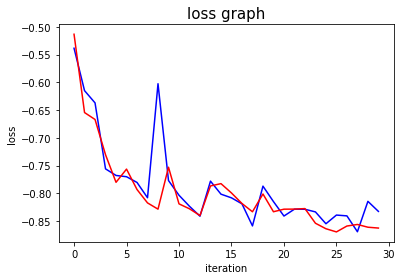

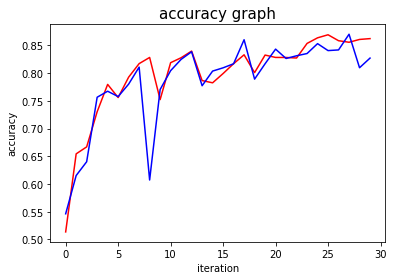

In [42]:
a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainjaccard = a['iou']
list_testjaccard = a['val_iou']

list_trainloss = a['loss']
list_testloss = a['val_loss']
plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()

In [ ]:
model = load_model('unet_brain_mri_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

In [ ]:
for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['mri_scan'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()

In [ ]:
# for layer in clf_model.layers:
#     layers.trainable = False

In [ ]:
model.compile(loss = 'categorical_crossentropy', 
              optimizer=Adam(lr=0.00001), 
              metrics= ["categorical_accuracy"]
             )

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=15
                             )
checkpointer = ModelCheckpoint(filepath="weights.h5", 
                               verbose=1, 
                               save_best_only=True
                              )
tensorboard = TensorBoard(log_dir = './logs',
                          histogram_freq=0,
                          batch_size=None,
                          write_graph=True,
                          write_grads=True,
                          write_images=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='auto',
                              verbose=1,
                              patience=2,
                              min_delta=0.0001,
                              factor=0.3
                             )
callbacks = [checkpointer, earlystopping, tensorboard,reduce_lr]

In [ ]:
# saving model achitecture in json file
model_json = model.to_json()
with open("clf-model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
h.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

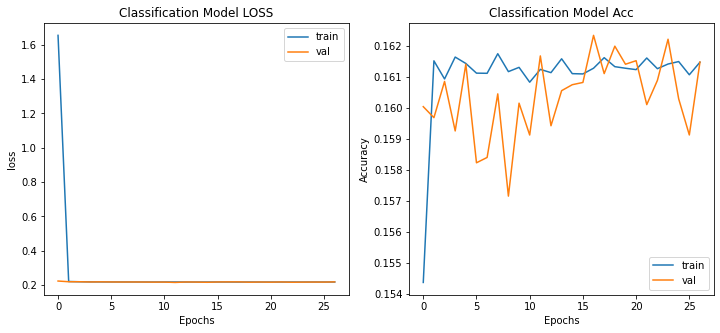

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['accuracy']);
plt.plot(h.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [ ]:
_, acc = model.evaluate(test_generator)
print("Test accuracy : {} %".format(acc*100))

19/19 [==============================] - 185s 10s/step - loss: 0.3698 - accuracy: 0.8765
Test accuracy : 87.64805197715759 %


In [ ]:
prediction = model.predict(test_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);

In [ ]:
h.history.keys()

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("SEG Model focal tversky Loss");
plt.ylabel("focal tversky loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['tversky']);
plt.plot(h.history['val_tversky']);
plt.title("SEG Model tversky score");
plt.ylabel("tversky Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [ ]:
test_ids = list(X_test.image_path)
test_mask = list(X_test.mask_path)
test_data = DataGenerator(test_ids, test_mask)
_, tv = seg_model.evaluate(test_data)
print("Segmentation tversky is {:.2f}%".format(tv*100))